In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import mne
import cupy as cp
import time 
import faiss
from math import remainder

current = time.time()
iteration_nbr = 0

for file_number in range(1,13):
    iteration_nbr += 1

    file_number_plus_one = file_number+1
    arr_fatigue = []
    arr_normal = []
    for i in range(file_number,file_number_plus_one):
        filename_normal = (f'Normal state{(i)}.cnt')
        f = mne.io.read_raw_cnt(filename_normal)
        df_normal_pat = f.to_data_frame()
        df_normal_pat = df_normal_pat.filter(['T6','P3','TP7','T4','T5','CP3'])
        df_normal_pat['FID'] = 0
        df_normal_pat['BT'] = i
        arr_normal.append(df_normal_pat)
        filename_fatigue = (f'Fatigue state{(i)}.cnt')
        f = mne.io.read_raw_cnt(filename_fatigue)
        df_fatigue_pat = f.to_data_frame()
        df_fatigue_pat = df_fatigue_pat.filter(['T6','P3','TP7','T4','T5','CP3'])
        df_fatigue_pat['FID']=1
        df_fatigue_pat['BT']=i
        arr_fatigue.append(df_fatigue_pat)

    df_normal = pd.concat(arr_normal)
    df_fatigue = pd.concat(arr_fatigue)
    normalized_df_normal=(df_normal-df_normal.min())/(df_normal.max()-df_normal.min())
    normalized_df_fatigue=(df_fatigue-df_fatigue.min())/(df_fatigue.max()-df_fatigue.min())

    fs = 1000                                # Sampling rate (1kHz)
    # Get real amplitudes of FFT (only in postive frequencies)
    fft_vals_T6_normal = np.absolute(np.fft.rfft(df_normal['T6']))
    fft_vals_P3_normal = np.absolute(np.fft.rfft(df_normal['P3']))
    fft_vals_TP7_normal = np.absolute(np.fft.rfft(df_normal['TP7']))
    #fft_vals_O1_normal = np.absolute(np.fft.rfft(df_normal['O1']))
    #fft_vals_OZ_normal = np.absolute(np.fft.rfft(df_normal['OZ']))
    fft_vals_T4_normal = np.absolute(np.fft.rfft(df_normal['T4']))
    fft_vals_T5_normal = np.absolute(np.fft.rfft(df_normal['T5']))
    #fft_vals_FC3_normal = np.absolute(np.fft.rfft(df_normal['FC3']))
    #fft_vals_FCZ_normal = np.absolute(np.fft.rfft(df_normal['FCZ']))
    fft_vals_CP3_normal = np.absolute(np.fft.rfft(df_normal['CP3']))

    fft_freq_T6_normal = np.fft.rfftfreq(len(df_normal['T6']), 1.0/fs)
    fft_freq_P3_normal = np.fft.rfftfreq(len(df_normal['P3']), 1.0/fs)
    fft_freq_TP7_normal = np.fft.rfftfreq(len(df_normal['TP7']), 1.0/fs)
    #fft_freq_O1_normal = np.fft.rfftfreq(len(df_normal['O1']), 1.0/fs)
    #fft_freq_OZ_normal = np.fft.rfftfreq(len(df_normal['OZ']), 1.0/fs)
    fft_freq_T4_normal = np.fft.rfftfreq(len(df_normal['T4']), 1.0/fs)
    fft_freq_T5_normal = np.fft.rfftfreq(len(df_normal['T5']), 1.0/fs)
    #fft_freq_FC3_normal = np.fft.rfftfreq(len(df_normal['FC3']), 1.0/fs)
    #fft_freq_FCZ_normal = np.fft.rfftfreq(len(df_normal['FCZ']), 1.0/fs)
    fft_freq_CP3_normal = np.fft.rfftfreq(len(df_normal['CP3']), 1.0/fs)

    fft_vals_T6_fatigue = np.absolute(np.fft.rfft(df_fatigue['T6']))
    fft_vals_P3_fatigue = np.absolute(np.fft.rfft(df_fatigue['P3']))
    fft_vals_TP7_fatigue = np.absolute(np.fft.rfft(df_fatigue['TP7']))
    #fft_vals_O1_fatigue = np.absolute(np.fft.rfft(df_fatigue['O1']))
    #fft_vals_OZ_fatigue = np.absolute(np.fft.rfft(df_fatigue['OZ']))
    fft_vals_T4_fatigue = np.absolute(np.fft.rfft(df_fatigue['T4']))
    fft_vals_T5_fatigue = np.absolute(np.fft.rfft(df_fatigue['T5']))
    #fft_vals_FC3_fatigue = np.absolute(np.fft.rfft(df_fatigue['FC3']))
    #fft_vals_FCZ_fatigue = np.absolute(np.fft.rfft(df_fatigue['FCZ']))
    fft_vals_CP3_fatigue = np.absolute(np.fft.rfft(df_fatigue['CP3']))

    fft_freq_T6_fatigue = np.fft.rfftfreq(len(df_fatigue['T6']), 1.0/fs)
    fft_freq_P3_fatigue = np.fft.rfftfreq(len(df_fatigue['P3']), 1.0/fs)
    fft_freq_TP7_fatigue = np.fft.rfftfreq(len(df_fatigue['TP7']), 1.0/fs)
    #fft_freq_O1_fatigue = np.fft.rfftfreq(len(df_fatigue['O1']), 1.0/fs)
    #fft_freq_OZ_fatigue = np.fft.rfftfreq(len(df_fatigue['OZ']), 1.0/fs)
    fft_freq_T4_fatigue = np.fft.rfftfreq(len(df_fatigue['T4']), 1.0/fs)
    fft_freq_T5_fatigue = np.fft.rfftfreq(len(df_fatigue['T5']), 1.0/fs)
    #fft_freq_FC3_fatigue = np.fft.rfftfreq(len(df_fatigue['FC3']), 1.0/fs)
    #fft_freq_FCZ_fatigue = np.fft.rfftfreq(len(df_fatigue['FCZ']), 1.0/fs)
    fft_freq_CP3_fatigue = np.fft.rfftfreq(len(df_fatigue['CP3']), 1.0/fs)

    # Define EEG bands
    eeg_bands = {'δ': (0.5, 4),
                 'θ': (4, 8),
                 'α': (8, 13),
                 'β': (13, 32),
                 'γ': (32, 100)}

    eeg_band_fft_T6_normal = dict()
    for band in eeg_bands:  
        freq_ix_T6_normal = np.where((fft_freq_T6_normal >= eeg_bands[band][0]) & 
                           (fft_freq_T6_normal <= eeg_bands[band][1]))[0]
        eeg_band_fft_T6_normal[band] = np.mean(fft_vals_T6_normal[freq_ix_T6_normal])

    df_T6_normal = pd.DataFrame(columns=['band', 'val'])
    df_T6_normal['band'] = eeg_bands.keys()
    df_T6_normal['val'] = [eeg_band_fft_T6_normal[band] for band in eeg_bands]
    df_T6_normal['fatigue'] = 0

    eeg_band_fft_T6_fatigue = dict()
    for band in eeg_bands:  
        freq_ix_T6_fatigue = np.where((fft_freq_T6_fatigue >= eeg_bands[band][0]) & 
                           (fft_freq_T6_fatigue <= eeg_bands[band][1]))[0]
        eeg_band_fft_T6_fatigue[band] = np.mean(fft_vals_T6_fatigue[freq_ix_T6_fatigue])

    df_T6_fatigue = pd.DataFrame(columns=['band', 'val'])
    df_T6_fatigue['band'] = eeg_bands.keys()
    df_T6_fatigue['val'] = [eeg_band_fft_T6_fatigue[band] for band in eeg_bands]
    df_T6_fatigue['fatigue'] = 1
    

    eeg_band_fft_P3_normal = dict()
    for band in eeg_bands:  
        freq_ix_P3_normal = np.where((fft_freq_P3_normal >= eeg_bands[band][0]) & 
                           (fft_freq_P3_normal <= eeg_bands[band][1]))[0]
        eeg_band_fft_P3_normal[band] = np.mean(fft_vals_P3_normal[freq_ix_P3_normal])

    df_P3_normal = pd.DataFrame(columns=['band', 'val'])
    df_P3_normal['band'] = eeg_bands.keys()
    df_P3_normal['val'] = [eeg_band_fft_P3_normal[band] for band in eeg_bands]
    df_P3_normal['fatigue'] = 0


    eeg_band_fft_P3_fatigue = dict()
    for band in eeg_bands:  
        freq_ix_P3_fatigue = np.where((fft_freq_P3_fatigue >= eeg_bands[band][0]) & 
                           (fft_freq_P3_fatigue <= eeg_bands[band][1]))[0]
        eeg_band_fft_P3_fatigue[band] = np.mean(fft_vals_P3_fatigue[freq_ix_P3_fatigue])

    df_P3_fatigue = pd.DataFrame(columns=['band', 'val'])
    df_P3_fatigue['band'] = eeg_bands.keys()
    df_P3_fatigue['val'] = [eeg_band_fft_P3_fatigue[band] for band in eeg_bands]
    df_P3_fatigue['fatigue'] = 1


    eeg_band_fft_TP7_normal = dict()
    for band in eeg_bands:  
        freq_ix_TP7_normal = np.where((fft_freq_TP7_normal >= eeg_bands[band][0]) & 
                           (fft_freq_TP7_normal <= eeg_bands[band][1]))[0]
        eeg_band_fft_TP7_normal[band] = np.mean(fft_vals_TP7_normal[freq_ix_TP7_normal])

    df_TP7_normal = pd.DataFrame(columns=['band', 'val'])
    df_TP7_normal['band'] = eeg_bands.keys()
    df_TP7_normal['val'] = [eeg_band_fft_TP7_normal[band] for band in eeg_bands]
    df_TP7_normal['fatigue'] = 0


    eeg_band_fft_TP7_fatigue = dict()
    for band in eeg_bands:  
        freq_ix_TP7_fatigue = np.where((fft_freq_TP7_fatigue >= eeg_bands[band][0]) & 
                           (fft_freq_TP7_fatigue <= eeg_bands[band][1]))[0]
        eeg_band_fft_TP7_fatigue[band] = np.mean(fft_vals_TP7_fatigue[freq_ix_TP7_fatigue])

    df_TP7_fatigue = pd.DataFrame(columns=['band', 'val'])
    df_TP7_fatigue['band'] = eeg_bands.keys()
    df_TP7_fatigue['val'] = [eeg_band_fft_TP7_fatigue[band] for band in eeg_bands]
    df_TP7_fatigue['fatigue'] = 1


    eeg_band_fft_T4_normal = dict()
    for band in eeg_bands:  
        freq_ix_T4_normal = np.where((fft_freq_T4_normal >= eeg_bands[band][0]) & 
                           (fft_freq_T4_normal <= eeg_bands[band][1]))[0]
        eeg_band_fft_T4_normal[band] = np.mean(fft_vals_T4_normal[freq_ix_T4_normal])

    df_T4_normal = pd.DataFrame(columns=['band', 'val'])
    df_T4_normal['band'] = eeg_bands.keys()
    df_T4_normal['val'] = [eeg_band_fft_T4_normal[band] for band in eeg_bands]
    df_T4_normal['fatigue'] = 0


    eeg_band_fft_T4_fatigue = dict()
    for band in eeg_bands:  
        freq_ix_T4_fatigue = np.where((fft_freq_T4_fatigue >= eeg_bands[band][0]) & 
                           (fft_freq_T4_fatigue <= eeg_bands[band][1]))[0]
        eeg_band_fft_T4_fatigue[band] = np.mean(fft_vals_T4_fatigue[freq_ix_T4_fatigue])

    df_T4_fatigue = pd.DataFrame(columns=['band', 'val'])
    df_T4_fatigue['band'] = eeg_bands.keys()
    df_T4_fatigue['val'] = [eeg_band_fft_T4_fatigue[band] for band in eeg_bands]
    df_T4_fatigue['fatigue'] = 1


    eeg_band_fft_T5_normal = dict()
    for band in eeg_bands:  
        freq_ix_T5_normal = np.where((fft_freq_T5_normal >= eeg_bands[band][0]) & 
                           (fft_freq_T5_normal <= eeg_bands[band][1]))[0]
        eeg_band_fft_T5_normal[band] = np.mean(fft_vals_T5_normal[freq_ix_T5_normal])

    df_T5_normal = pd.DataFrame(columns=['band', 'val'])
    df_T5_normal['band'] = eeg_bands.keys()
    df_T5_normal['val'] = [eeg_band_fft_T5_normal[band] for band in eeg_bands]
    df_T5_normal['fatigue'] = 0


    eeg_band_fft_T5_fatigue = dict()
    for band in eeg_bands:  
        freq_ix_T5_fatigue = np.where((fft_freq_T5_fatigue >= eeg_bands[band][0]) & 
                           (fft_freq_T5_fatigue <= eeg_bands[band][1]))[0]
        eeg_band_fft_T5_fatigue[band] = np.mean(fft_vals_T5_fatigue[freq_ix_T5_fatigue])

    df_T5_fatigue = pd.DataFrame(columns=['band', 'val'])
    df_T5_fatigue['band'] = eeg_bands.keys()
    df_T5_fatigue['val'] = [eeg_band_fft_T5_fatigue[band] for band in eeg_bands]
    df_T5_fatigue['fatigue'] = 1
    

    eeg_band_fft_CP3_normal = dict()
    for band in eeg_bands:  
        freq_ix_CP3_normal = np.where((fft_freq_CP3_normal >= eeg_bands[band][0]) & 
                           (fft_freq_CP3_normal <= eeg_bands[band][1]))[0]
        eeg_band_fft_CP3_normal[band] = np.mean(fft_vals_CP3_normal[freq_ix_CP3_normal])

    df_CP3_normal = pd.DataFrame(columns=['band', 'val'])
    df_CP3_normal['band'] = eeg_bands.keys()
    df_CP3_normal['val'] = [eeg_band_fft_CP3_normal[band] for band in eeg_bands]
    df_CP3_normal['fatigue'] = 0
    

    eeg_band_fft_CP3_fatigue = dict()
    for band in eeg_bands:  
        freq_ix_CP3_fatigue = np.where((fft_freq_CP3_fatigue >= eeg_bands[band][0]) & 
                           (fft_freq_CP3_fatigue <= eeg_bands[band][1]))[0]
        eeg_band_fft_CP3_fatigue[band] = np.mean(fft_vals_CP3_fatigue[freq_ix_CP3_fatigue])

    df_CP3_fatigue = pd.DataFrame(columns=['band', 'val'])
    df_CP3_fatigue['band'] = eeg_bands.keys()
    df_CP3_fatigue['val'] = [eeg_band_fft_CP3_fatigue[band] for band in eeg_bands]
    df_CP3_fatigue['fatigue'] = 1
    





    dict_fft_fatigue = {'eeg_band_fft_CP3_fatigue':eeg_band_fft_CP3_fatigue,
                         #'eeg_band_fft_FC3_fatigue':eeg_band_fft_FC3_fatigue,
                         #'eeg_band_fft_FCZ_fatigue':eeg_band_fft_FCZ_fatigue,
                         #'eeg_band_fft_O1_fatigue':eeg_band_fft_O1_fatigue,
                         #'eeg_band_fft_OZ_fatigue':eeg_band_fft_OZ_fatigue,
                         'eeg_band_fft_P3_fatigue':eeg_band_fft_P3_fatigue,
                         'eeg_band_fft_T4_fatigue':eeg_band_fft_T4_fatigue,
                         'eeg_band_fft_T5_fatigue':eeg_band_fft_T5_fatigue,
                         'eeg_band_fft_T6_fatigue':eeg_band_fft_T6_fatigue,
                         'eeg_band_fft_TP7_fatigue':eeg_band_fft_TP7_fatigue}

    dict_fft_normal = {'eeg_band_fft_CP3_normal':eeg_band_fft_CP3_normal,
                         #'eeg_band_fft_FC3_normal':eeg_band_fft_FC3_normal,
                         #'eeg_band_fft_FCZ_normal':eeg_band_fft_FCZ_normal,
                         #'eeg_band_fft_O1_normal':eeg_band_fft_O1_normal,
                         #'eeg_band_fft_OZ_normal':eeg_band_fft_OZ_normal,
                         'eeg_band_fft_P3_normal':eeg_band_fft_P3_normal,
                         'eeg_band_fft_T4_normal':eeg_band_fft_T4_normal,
                         'eeg_band_fft_T5_normal':eeg_band_fft_T5_normal,
                         'eeg_band_fft_T6_normal':eeg_band_fft_T6_normal,
                         'eeg_band_fft_TP7_normal':eeg_band_fft_TP7_normal}
    
    
    def coefficient_multiplication_adding_columns(coeff_dict, dataset):
        # order is delta, theta, alpha beta, gamma
        list_waves = ['δ','θ','α','β','γ']

        # here I iterate over number of elements in dictionary

        for electrode in range(len(coeff_dict)):

        # this loop matches the column of the Df with the name of the electrode - the loop below and the if statement
            for i in range(len(dataset.columns)):
                column_name = '_'+dataset.columns[i]+'_'

                if column_name in list(coeff_dict.keys())[electrode]:


                    #for loop below iterates over ranges of frequency α and the others:

                    for frequency_range in list_waves:
                        new_column = dataset.columns[i]+frequency_range
                        dataset[f'{new_column}'] = 1.0
                        current_coefficient = coeff_dict[list(coeff_dict.keys())[electrode]][frequency_range]

                        # loop below loops over rows and goes to specific cell; then calculates the new number

                        #for row_number in range(len(dataset[f'{new_column}'])):
                            #dataset.at[row_number, new_column] = dataset[dataset.columns[i]][row_number]*current_coefficient

            


    def coefficient_multiplication_cpu(coeff_dict, dataset):
        # order is delta, theta, alpha beta, gamma
        list_waves = ['δ','θ','α','β','γ']

        # here I iterate over number of elements in dictionary

        for electrode in range(len(coeff_dict)):

        # this loop matches the column of the Df with the name of the electrode - the loop below and the if statement
            for i in range(len(dataset.columns)):
                column_name = '_'+dataset.columns[i]+'_'

                if column_name in list(coeff_dict.keys())[electrode]:

                    #for loop below iterates over ranges of frequency α and the others:

                    for frequency_range in list_waves:

                        new_column = dataset.columns[i]+frequency_range
                        dataset[f'{new_column}'] = dataset[dataset.columns[i]]
                        current_coefficient = coeff_dict[list(coeff_dict.keys())[electrode]][frequency_range]

                        # loop below loops over rows and goes to specific cell; then calculates the new number

                        dataset[new_column] = dataset[new_column]*current_coefficient



    def coefficient_multiplication_gpu(coeff_dict, dataset):
        # order is delta, theta, alpha beta, gamma
        list_waves = ['δ','θ','α','β','γ']
        covered_electrodes = []
        force_break = 0

        coefficient_multiplication_adding_columns(coeff_dict, dataset)
        gpu_array = array_creation_GPU(dataset)
        # here I iterate over number of elements in dictionary
        for electrode in range(len(coeff_dict)):

        # this loop and if statements extracts the name of the required electrode
            for i in range(len(dataset.columns)):

                column_name = '_'+dataset.columns[i]+'_'
                if column_name in list(coeff_dict.keys())[electrode]:
                    column_name = dataset.columns[i]


        # here I make sure name of electrode has not been covered and will not get covered in the future

                    if column_name not in covered_electrodes:
                        covered_electrodes.append(column_name)

        # here i iterate over frequency ranges (alpha etc) and I find the specific column that I am looking for

                        for frequency_range in list_waves:
                            specific_column = column_name+frequency_range
                            covered_electrodes.append(specific_column)
                            for j in range(len(dataset.columns)):
                                #print(f'value of j: {j}')
                                if specific_column == dataset.columns[j]:
                                    current_coefficient = cp.array([coeff_dict[list(coeff_dict.keys())[electrode]][frequency_range]])
                                    gpu_array[j] = gpu_array[i]*current_coefficient
        return gpu_array




    def filtering_dataset(dataset):
        list_waves = ['δ','θ','α','β','γ']
        temp_list = []
        dict_df = {}
        for j in dataset.columns:
            temp_list = []
            if j == 'FID':
                break
            for symbol in list_waves:
                temp_list.append(f'{j+symbol}')
            temp_list.extend(['FID','BT'])
            dict_df['dataset_{}'.format(j)] = df_full.filter(temp_list)
        return dict_df

    def array_creation_GPU(dataset):
        temp_array = dataset.to_numpy()
        array_transposed = np.transpose(temp_array)
        GPU_array = cp.array(array_transposed)
        return GPU_array

 
  # multiplying the datasets
    
    coefficient_multiplication_cpu(dict_fft_fatigue,df_fatigue)
    coefficient_multiplication_cpu(dict_fft_normal,df_normal)


    
    temp_file = pd.concat([df_fatigue,df_normal],axis=0)
    temp_file = temp_file.sample(frac=1)
    
    y_temp = temp_file.filter(['FID'])
    x_temp = temp_file.drop(['T6','P3','TP7','T4','T5','CP3','FID','BT'],axis=1)
    
    y_temp = y_temp.to_numpy()
    x_temp = x_temp.to_numpy()

    
    if iteration_nbr > 1:
                
        final_y = np.vstack ((final_y, y_temp))
        final_x = np.vstack ((final_x, x_temp))

    else:

        final_y = y_temp
        final_x = x_temp
        
print('file is done')
end = time.time()
final = end-current
print(f'time ran in seconds {final}')



/tmp/ipykernel_12427/1920400493.py:25: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  f = mne.io.read_raw_cnt(filename_normal)
/tmp/ipykernel_12427/1920400493.py:25: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  f = mne.io.read_raw_cnt(filename_normal)
/tmp/ipykernel_12427/1920400493.py:32: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  f = mne.io.read_raw_cnt(filename_fatigue)
/home/oliver/anaconda3/lib/python3.9/site-packages/mne/io/cnt/cnt.py:241: RuntimeWarning: overflow encountered in int_scalars
  data_size // (n_samples * n_channels) not in [2, 4]):
/tmp/ipykernel_12427/1920400493.py:32: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  f = mne.io.read_raw_cnt(filename_fatigue)
/tmp/ipykernel_12427/1920400493.py:25: RuntimeWarning:   Could not parse meas date from the header. Setting to None.
  f = mne.io.read_raw_cnt(filename_normal)
/t

file is done
time ran in seconds 65.5586199760437


In [2]:
final_y.shape[0]

14436640

In [3]:
final_x.shape

(14436640, 30)

### Upgraded Faiss KNN

In [4]:
class FaissKNeighborsCPU:
    
    
    def __init__(self, k=5):
        self.index = None
        self.y = None
        self.k = k

    def fit(self, X, y):
        self.index = faiss.IndexFlatL2(X.shape[1])
        self.index.add(X.astype(np.float32))
        self.y = y

    def predict(self, X):
        force_break = 0 
        distances, indices = self.index.search(X.astype(np.float32), k=self.k)
        votes = self.y[indices]
        votes.shape
        for x in votes:
            force_break +=1
            if force_break >10:
                break
        predictions = np.array([np.argmax(np.bincount(x.flatten())) for x in votes])
        print(predictions)
        return predictions

### the part of the code below is not scalable

x = np.delete(final_file,[0,1],1)

y = np.delete(final_file,1,1)

y.shape

#### next step: take the decimal points. if equal next to 0, then make all numbers integers then run function

In [5]:
11.000000%1

0.0

In [6]:
trial_num1 = 1
if trial_num1 == (0 or 1):
    print('works')

works


if temp_number1%1 == 0.0 and temp_number == 0 or 1:
    value = int(value)


y_range = y.shape[1]

for i in range(y_range-1):
    print(f'i is{i}; while y shape is {y_range}')
    i +=1
    y = np.delete(y,1,1)

final_file = 0


In [7]:

# In[ ]:


x_train,x_test,y_train,y_test = train_test_split(final_x,final_y,test_size = 0.2,random_state=5)


# In[ ]:


classifier_full_data = FaissKNeighborsCPU()


# In[ ]:


classifier_full_data.fit(x_train,y_train)


# In[ ]:


[1 0 0 ... 0 1 0]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1444169
           1       1.00      1.00      1.00   1443159

    accuracy                           1.00   2887328
   macro avg       1.00      1.00      1.00   2887328
weighted avg       1.00      1.00      1.00   2887328



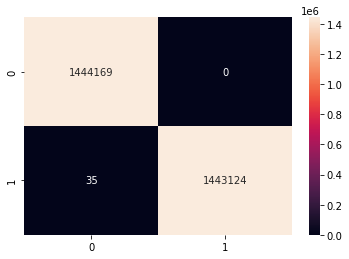

In [8]:

y_predict_full = classifier_full_data.predict(x_test)


# In[ ]:


cm = confusion_matrix(y_test,y_predict_full)


# In[ ]:


sns.heatmap(cm,annot=True,fmt = 'd')


# In[ ]:


print(classification_report(y_test,y_predict_full))



In [9]:
import os
os.system('spd-say "your program has finished"')

0